#Download Crop Faces


In [ ]:
%cd /content/WIKI_CROP
!wget https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki/static/wiki_crop.tar

In [ ]:
!tar -xvf wiki_crop.tar

#Multnomial Classifier


##Train & Test

In [ ]:
# scikit Tools
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from PIL import Image
from google.colab.patches import cv2_imshow
from scipy.io import loadmat
import numpy as np
import cv2

np.set_printoptions(threshold=np.inf)



# Return bin classification
def classify(age):
  if age < 0:
    return -1
  elif 0 <= age < 20:
    return 0
  elif 20 <= age < 40:
    return 1
  elif 40 <= age < 60:
    return 2
  elif 60 <= age < 80:
    return 3
  elif 80 <= age <= 100:
    return 4



# Model
model = LogisticRegression()

# Key info.
FEATURES = 16
images = []
age_range = []
added = 0

# Load data
annots = loadmat("/content/WIKI_CROP/wiki_crop/wiki.mat")
wiki = annots['wiki'][0][0]

# Prepare training/testing set
start = 0
end = 100
for i in range(start, end):

  ctr = 0

  # Image
  filename = wiki[2][0][i][0]
  img = cv2.imread("/content/WIKI_CROP/wiki_crop/" + filename)

  # Real Age
  born = wiki[0][0][i]
  pic_time = wiki[1][0][i]
  real_age = pic_time - int(born / 365)

  # SIFT
  sift = cv2.SIFT_create(nfeatures = FEATURES)
  keypoints, descriptors = sift.detectAndCompute(img, None)

  if i == 0:
    descriptors = np.array(descriptors)
    print("Vector length per keypoint: " + str(descriptors[0].size))
    print("Keypoints: " + str(FEATURES))
    print("N-dimensional linear vector: " + str(descriptors[0].size * FEATURES) + "\n")

  pts_arr = np.array([cv2.KeyPoint_convert(keypoints)]) # Convert to NumPy for scikit
  img = cv2.drawKeypoints(img, keypoints, None)


  try:

    for item in pts_arr[0]:
      ctr += 1

    # SIFT doesn't extract features from certain images
    if(ctr == 0):
      continue

    if i == 0:
      # First image may not detect nfeatures=FEATURES, so pad initially
      data = [np.array([0, 0])]

      for z in range(1, FEATURES):
        data = np.vstack((data, [0, 0]))

      data = [data]
      data = np.vstack((data, pts_arr))

    else:
      data = np.vstack((data, pts_arr))

  except:

    pass

    # Ensure equal dimensionality
    if ctr > FEATURES:

      while (ctr > FEATURES): # Remove features from larger array
        pts_arr = [np.delete(pts_arr[0], ctr - 1, axis=0)]
        ctr -= 1

    else:

      while (ctr < FEATURES): # Pad zeroes for array with few features
        pts_arr = [np.vstack((pts_arr[0], [0, 0]))]
        ctr += 1

    data = np.vstack((data, pts_arr))

  # Remove inital padding from data set
  if i == 0:
    data = np.delete(data, 0, axis=0)

  # Classify age group
  classification = classify(real_age)
  age_range.append(classification)
  str_range = ""
  match classification:
      case 0:
        str_range = "[0 - 20)"
      case 1:
        str_range = "[20 - 40)"
      case 2:
        str_range = "[40 - 60)"
      case 3:
        str_range = "[60 - 80)"
      case 4:
        str_range = "[80 - 100]"
  print("AGE RANGE: " + str_range)
  print("  REAL:    " + str(real_age))
  cv2_imshow(img)
  added += 1

# Certain images aren't added (SIFT unable to detect key features)
print("\nAdded to data set: " + str(added) + " - Should be: " + str(end))

# 80% training, 20% testing
X_train, X_test, Y_train, Y_test = train_test_split(data, age_range, test_size = 0.2)
X_train = X_train.reshape(X_train.shape[0], -1)

# Linear fit, then test model
model.fit(X_train, Y_train)
X_test = X_test.reshape(X_test.shape[0], -1)
print("Score: " + str(model.score(X_test, Y_test)))


##Predict

PREDICTION: [20 - 40)
REAL AGE: 68
WRONG


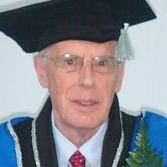

PREDICTION: [0 - 20)
REAL AGE: 21
WRONG


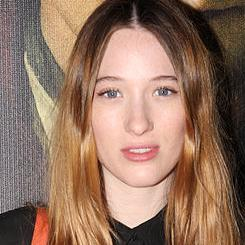

PREDICTION: [60 - 80)
REAL AGE: 19
WRONG


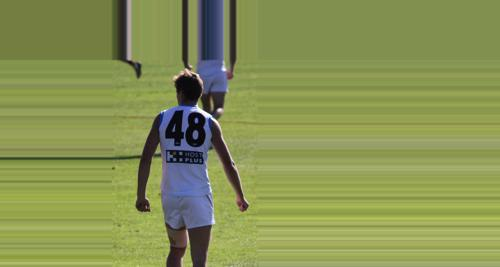

PREDICTION: [20 - 40)
REAL AGE: 39
CORRECT


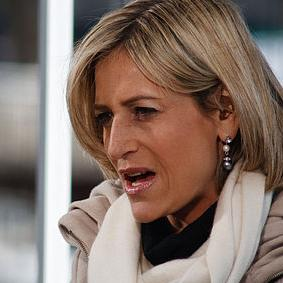

PREDICTION: [20 - 40)
REAL AGE: 22
CORRECT


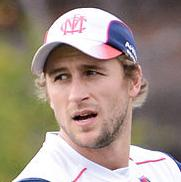

PREDICTION: [60 - 80)
REAL AGE: 65
CORRECT


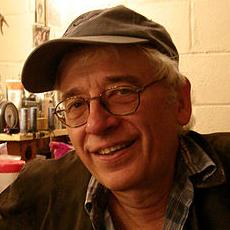

PREDICTION: [20 - 40)
REAL AGE: 58
WRONG


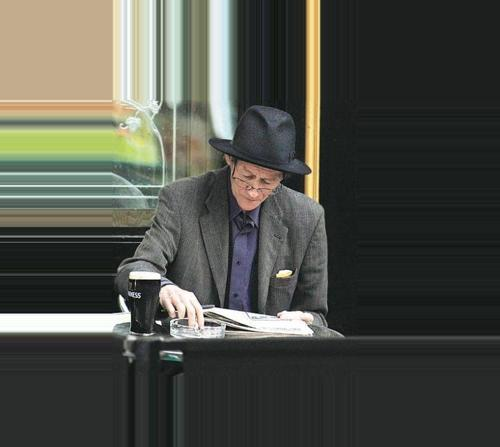

PREDICTION: [0 - 20)
REAL AGE: 19
CORRECT


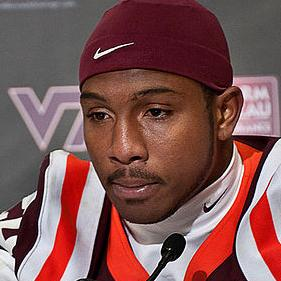

PREDICTION: [20 - 40)
REAL AGE: 20
CORRECT


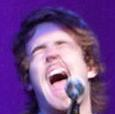

PREDICTION: [20 - 40)
REAL AGE: 30
CORRECT


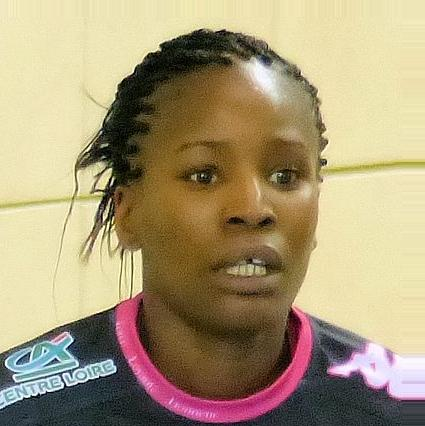

PREDICTION: [0 - 20)
REAL AGE: 47
WRONG


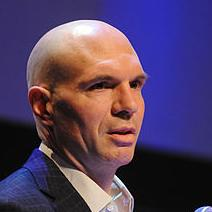

PREDICTION: [60 - 80)
REAL AGE: 54
WRONG


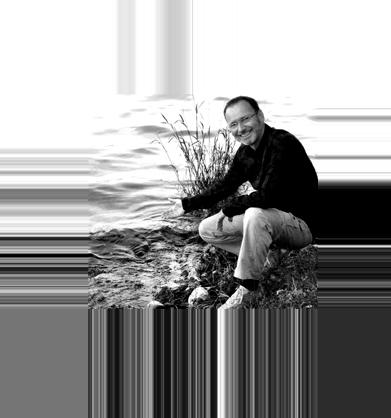

PREDICTION: [40 - 60)
REAL AGE: 48
CORRECT


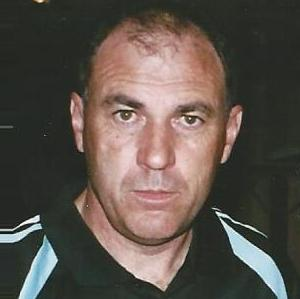

PREDICTION: [40 - 60)
REAL AGE: 29
WRONG


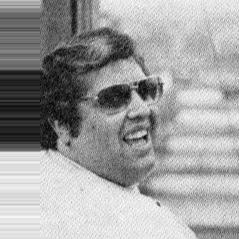

PREDICTION: [40 - 60)
REAL AGE: 23
WRONG


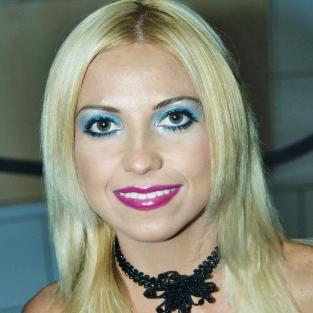

Accuracy: 0.7


In [ ]:
# Key info.
data = []
skip = []
hist_age = []

predict_start = 62000
predict_end = predict_start + 20

for i in range(predict_start, predict_end):

  ctr = 0

  # Image
  filename = wiki[2][0][i][0]
  img = cv2.imread("/content/WIKI_CROP/wiki_crop/" + filename)

  # Real Age
  born = wiki[0][0][i]
  pic_time = wiki[1][0][i]
  real_age = pic_time - int(born / 365)

  # SIFT
  sift = cv2.SIFT_create(nfeatures = FEATURES)
  keypoints, descriptors = sift.detectAndCompute(img, None)
  pts_arr = np.array([cv2.KeyPoint_convert(keypoints)]) # Convert to NumPy for scikit
  img = cv2.drawKeypoints(img, keypoints, None)

  try:

    for item in pts_arr[0]:
      ctr += 1

    # SIFT doesn't extract features from certain images
    if(ctr == 0):
      skip.append(i)
      continue

    if i == predict_start:
      data = [np.array([0, 0])]

      for z in range(1, FEATURES):
        data = np.vstack((data, [0, 0]))

      data = [data]
      data = np.vstack((data, pts_arr))

    else:
      data = np.vstack((data, pts_arr))

  except:

    pass

    # Ensure equal dimensionality
    if ctr > FEATURES:

      while (ctr > FEATURES): # Remove features from larger array
        pts_arr = [np.delete(pts_arr[0], ctr - 1, axis=0)]
        ctr -= 1

    else:

      while (ctr < FEATURES): # Pad zeroes for array with few features
        pts_arr = [np.vstack((pts_arr[0], [0, 0]))]
        ctr += 1

    data = np.vstack((data, pts_arr))

    # Remove initial padding
    if i == end + 1:
      data = np.delete(data, 0, axis=0)

  hist_age.append(real_age)

# Print predictions
index = 0
skipped = 0
data = data.reshape(data.shape[0], -1)
prediction = model.predict(data)
correct_predictions = 0
for i in range(predict_start, predict_end):

  # Corrupted images (very few of them)
  if i in skip:
    skipped += 1
    continue

  # Image
  filename = wiki[2][0][i][0]
  img = cv2.imread("/content/WIKI_CROP/wiki_crop/" + filename)

  # Real Age
  born = wiki[0][0][i]
  pic_time = wiki[1][0][i]
  real_age = pic_time - int(born / 365)

  str_range = ""
  predict_age = prediction[index]
  match predict_age:
      case 0:
        str_range = "[0 - 20)"
      case 1:
        str_range = "[20 - 40)"
      case 2:
        str_range = "[40 - 60)"
      case 3:
        str_range = "[60 - 80)"
      case 4:
        str_range = "[80 - 100]"
  print("PREDICTION: " + str_range)
  print("REAL AGE: " + str(real_age))
  in_range = bool(False)
  match str_range:
      case "[0 - 20)":
        in_range = bool(0 <= real_age < 20)
      case "[20 - 40)":
        in_range = bool(20 <= real_age < 40)
      case "[40 - 60)":
        in_range = bool(40 <= real_age < 60)
      case "[60 - 80)":
        in_range = bool(60 <= real_age < 80)
      case "[80 - 100]":
        in_range = bool(80 <= real_age <= 100)
  if in_range:
    correct_predictions += 1
    print("CORRECT")
  else:
    print("WRONG")


  index += 1
  cv2_imshow(img)

print("Accuracy: " + str(correct_predictions / (index - skipped)))




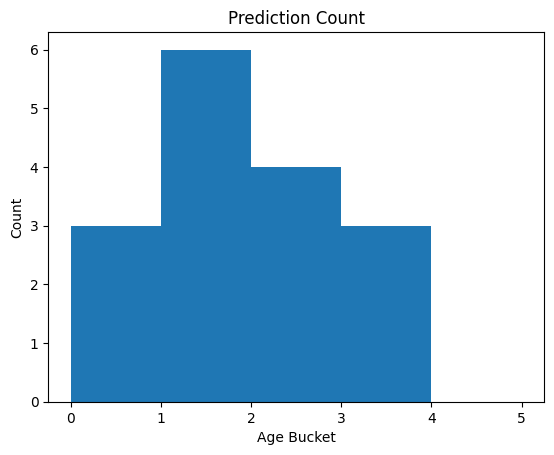

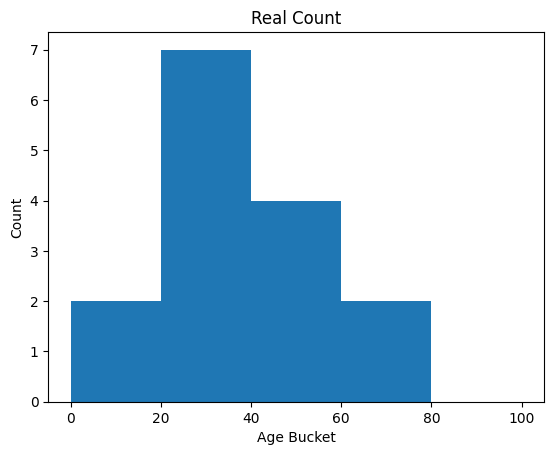

In [ ]:
import matplotlib.pyplot as plt

# Histogram
fig, ax = plt.subplots()
buckets = [0, 1, 2, 3, 4, 5]
plt.hist(prediction, buckets)
plt.title("Prediction Count")
plt.xlabel("Age Bucket")
plt.ylabel("Count")
ax.set_xticks((0, 1, 2, 3, 4, 5))
plt.show()
print("\n")

# Histogram
fig, ax = plt.subplots()
buckets = [0, 20, 40, 60, 80, 100]
plt.hist(hist_age, buckets)
plt.title("Real Count")
plt.xlabel("Age Bucket")
plt.ylabel("Count")
ax.set_xticks((0, 20, 40, 60, 80, 100))
plt.show()